<a href="https://colab.research.google.com/github/jetafese/btor2mlir/blob/ebpf/utils/ebpf/results/ebpf_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#eBPF Experiment Results


## Setup & Utilities

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Do not limit number of rows displayed
pd.set_option('display.max_rows', None)

/tmp/ipykernel_609918/1105105565.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
TIMEOUTMAX = 20
MEMOUTMAX = 300000

def clean_csv(in_file, ref=False):
  df = pd.read_csv(in_file)
  # drop rows that don't belong
  df = df[df["File"].str.contains("/ebpf-samples") == True]
  assert (df.count()['File'] == 369)
  # get program name, ignore full path
  df[['path', 'program']] = df['File'].str.split(pat = '/ebpf-samples', expand = True)
  df = df.drop(columns=['path', 'File'])
  # distinguish between reference results and current results
  if ref:
    df = df.rename(columns = {'Result': 'prevail'})
    df = df.rename(columns = {'Cpu': 'prevail_t'})
    df = df.rename(columns = {'Mem': 'prevail_m'})
    df = df[['program', 'prevail', 'prevail_t', 'prevail_m']]
    # handle NAs
    df['prevail_t'] = df['prevail_t'].fillna(TIMEOUTMAX)
    df['prevail_m'] = df['prevail_m'].fillna(MEMOUTMAX)
  else:
    df = df.rename(columns = {'Result': 'result'})
    # extract seahorn time
    df[['title', 'sea_time']] = df['seahorn_time'].str.split(pat = 'seahorn_total', expand = True)
    df = df.drop(columns=['title', 'seahorn_time'])
    # extract total time
    df[['time', 'mem_total']] = df['total'].str.split(pat = 'user', expand = True)
    df = df.drop(columns=['total'])
    # extract total memory
    df[['extra_1', 'mem_s']] = df['mem_total'].str.split(pat = '0avgdata', expand = True)
    df[['mem', 'extra_2']] = df['mem_s'].str.split(pat = 'maxresident', expand = True)
    df = df.drop(columns=['extra_1', 'mem_s', 'extra_2'])
    df = df[['program', 'result', 'trivial', 'sea_time', 'time', 'mem']]
    # handle NAs
    df['trivial'] = df['trivial'].fillna(0)
    df.loc[df['result'].str.contains('error'), 'mem'] = MEMOUTMAX
    df.loc[df['result'].str.contains('error'), 'time'] = TIMEOUTMAX
  return df

## Collect CSVs

In [3]:
#include csv for reference, current results
CURRENT = "/home/jetafese/btor2mlir/utils/ebpf/results/prevail_0920240753.csv"
REFERENCE = "/home/jetafese/btor2mlir/utils/ebpf/results/ref_prevail_0425241000.csv"

current_results = clean_csv(CURRENT)
ref_results = clean_csv(REFERENCE, ref=True)
# current_results
# ref_results

## Interesting points

In [4]:
trivialForSeahorn = pd.merge(current_results, ref_results, how='inner', on='program')
trivialForSeahorn[trivialForSeahorn['trivial'] == 1.0]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
52,/build/badhelpercall.o:.text,1,1.0,0.01,0.37,89072,0,0.000580,4408.0
72,/build/ringbuf_uninit.o:.text,1,1.0,0.01,0.35,89364,0,0.000751,4448.0
74,/build/tail_call_bad.o:xdp_prog,1,1.0,0.01,0.37,89632,0,0.000349,4580.0
75,/build/tail_call_bad.o:xdp_prog/0,1,1.0,0.01,0.36,89420,1,0.000156,4252.0
76,/build/tail_call.o:xdp_prog,1,1.0,0.01,0.36,89228,1,0.000385,4332.0
77,/build/tail_call.o:xdp_prog/0,1,1.0,0.01,0.37,89636,1,0.000188,4400.0
212,/linux/task_fd_query_kern.o:kprobe/blk_start_r...,1,1.0,0.01,0.33,89672,1,0.000161,4444.0
213,/linux/task_fd_query_kern.o:kretprobe/blk_acco...,1,1.0,0.01,0.34,89516,1,0.000151,4424.0
234,/linux/test_overhead_kprobe_kern.o:kprobe/uran...,1,1.0,0.01,0.35,89352,1,0.000144,4392.0
235,/linux/test_overhead_raw_tp_kern.o:raw_tracepo...,1,1.0,0.01,0.35,89660,1,0.000157,4264.0


## Checking Disparities

### Soundness checks

In [5]:
mergedDF = pd.merge(current_results, ref_results, how='inner', on='program')
eqs = mergedDF['result'] == mergedDF['prevail']
diff = mergedDF['result'] != mergedDF['prevail']
print('ebpf2mlir agrees with prevail on: ', eqs.sum(), ', and differs on: ', diff.sum(), ' programs')

ebpf2mlir agrees with prevail on:  204 , and differs on:  165  programs


In [6]:
# resultAndNOTPrevail = mergedDF.query('result > prevail')
resultAndNOTPrevail = mergedDF[mergedDF['result'].str.startswith("1") & mergedDF['prevail'].str.startswith("0")]
print('total cases where result == 1 and prevail == 0...', resultAndNOTPrevail.count()['program'])
resultAndNOTPrevail

total cases where result == 1 and prevail == 0... 14


,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
52,/build/badhelpercall.o:.text,1,1.0,0.01,0.37,89072,0,0.000580,4408.0
53,/build/badmapptr.o:test,1,0.0,0.03,0.42,91480,0,0.000844,4440.0
55,/build/ctxoffset.o:sockops,1,0.0,0.04,0.41,90440,0,0.001608,5224.0
56,/build/exposeptr2.o:.text,1,0.0,0.03,0.40,91568,0,0.002006,4408.0
57,/build/exposeptr.o:.text,1,0.0,0.03,0.42,91784,0,0.002352,4156.0
58,/build/loop.o:test_md,1,0.0,0.07,0.92,93068,0,0.020983,5588.0
66,/build/nullmapref.o:test,1,0.0,0.04,0.39,91692,0,0.001822,5080.0
68,/build/packet_overflow.o:xdp,1,0.0,0.10,0.48,97300,0,0.000973,4300.0
72,/build/ringbuf_uninit.o:.text,1,1.0,0.01,0.35,89364,0,0.000751,4448.0
74,/build/tail_call_bad.o:xdp_prog,1,1.0,0.01,0.37,89632,0,0.000349,4580.0


In [8]:
prevailAndNotResult = mergedDF[mergedDF['result'].str.startswith("0") & mergedDF['prevail'].str.startswith("1")]
print('total cases where result == 0 and prevail == 1...', prevailAndNotResult.count()['program'])
# prevailAndNotResult.sort_values('prevail_t')

total cases where result == 0 and prevail == 1... 86


In [9]:
prevailAndErrorResult = mergedDF[mergedDF['result'].str.startswith("error") & mergedDF['prevail'].str.startswith("1")]
print('total cases where result == error and prevail == 1...', prevailAndErrorResult.count()['program'])
# prevailAndErrorResult

total cases where result == error and prevail == 1... 5


In [10]:
NotPrevailAndErrorResult = mergedDF[mergedDF['result'].str.startswith("error") & mergedDF['prevail'].str.startswith("0")]
print('total cases where result == error and prevail == 0...', NotPrevailAndErrorResult.count()['program'])
# NotPrevailAndErrorResult

total cases where result == error and prevail == 0... 32


In [11]:
ErrorResultAndErrorPrevail = mergedDF[mergedDF['result'].str.startswith("error") & mergedDF['prevail'].str.contains("error")]
print('total cases where result == error and prevail == error...', ErrorResultAndErrorPrevail.count()['program'])
# ErrorResultAndErrorPrevail

total cases where result == error and prevail == error... 6


In [12]:
resultAndErrorPrevail = mergedDF[mergedDF['result'].str.startswith("1") & mergedDF['prevail'].str.contains("error")]
print('total cases where result == 1 and prevail == error...', resultAndErrorPrevail.count()['program'])
# resultAndErrorPrevail

total cases where result == 1 and prevail == error... 9


In [13]:
NotResultAndErrorPrevail = mergedDF[mergedDF['result'].str.startswith("0") & mergedDF['prevail'].str.contains("error")]
print('total cases where result == 0 and prevail == error...', NotResultAndErrorPrevail.count()['program'])
# NotResultAndErrorPrevail

total cases where result == 0 and prevail == error... 13


## Failing Pipelines


In [14]:
failures = pd.merge(current_results, ref_results, how='inner', on='program')
print('total number of failures: ', failures[failures['result'].str.contains("error")].count()['result'])
print('failures due to llvm casting: ', failures[failures['result'].str.contains("llvm dialect")].count()['result'])
print('failures due to translation code: ', failures[failures['result'].str.contains("translation")].count()['result'])
print('failures due to seahorn timeout: ', failures[failures['result'].str.contains("timeout")].count()['result'])

total number of failures:  43
failures due to llvm casting:  36
failures due to translation code:  4
failures due to seahorn timeout:  3


### llvm casting bug (dialect conversion)

In [15]:
castingBug = pd.merge(current_results, ref_results, how='inner', on='program')
castingBug[castingBug['result'].str.contains("llvm")]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
31,/bpf_cilium_test/bpf_lxc_jit.o:2/10,error: to llvm dialect conversion failed,0.0,NaN,20,300000,unmarshaling error at 21: bad instruction op 0x30,20.000000,300000.0
32,/bpf_cilium_test/bpf_lxc_jit.o:2/7,error: to llvm dialect conversion failed,0.0,NaN,20,300000,1,13.984400,116156.0
35,/bpf_cilium_test/bpf_lxc_jit.o:1/0xdc06,error: to llvm dialect conversion failed,0.0,NaN,20,300000,1,10.103400,63012.0
89,/cilium/bpf_lxc.o:2/10,error: to llvm dialect conversion failed,0.0,NaN,20,300000,unmarshaling error at 22: bad instruction op 0x30,20.000000,300000.0
111,/cilium/bpf_xdp_dsr_linux.o:2/21,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,0.480340,24180.0
112,/cilium/bpf_xdp_dsr_linux.o:2/16,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,9.190760,208284.0
113,/cilium/bpf_xdp_dsr_linux.o:2/18,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,0.623473,46064.0
114,/cilium/bpf_xdp_dsr_linux.o:2/24,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,4.956300,176380.0
116,/cilium/bpf_xdp_dsr_linux.o:2/15,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,14.822500,231148.0
120,/cilium/bpf_xdp_dsr_linux.o:2/10,error: to llvm dialect conversion failed,0.0,NaN,20,300000,0,0.175166,20188.0


### many exits in program (translation)

In [16]:
translationBug = pd.merge(current_results, ref_results, how='inner', on='program')
translationBug[translationBug['result'].str.contains("translation")]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
54,/build/byteswap.o:.text,error: translation failed,0.0,NaN,20,300000,1,0.003497,5164.0
71,/build/prog_array.o:.text,error: translation failed,0.0,NaN,20,300000,1,0.000282,4452.0
82,/build/wronghelper.o:xdp,error: translation failed,0.0,NaN,20,300000,unmarshaling error at 7: invalid helper functi...,20.000000,300000.0
167,/invalid/invalid-lddw.o:.text,error: translation failed,0.0,NaN,20,300000,unmarshaling error at 1: incomplete lddw,20.000000,300000.0


### seahorn timeout 

In [17]:
timeouts = pd.merge(current_results, ref_results, how='inner', on='program')
timeouts[timeouts['result'].str.contains("timeout")]

,program,result,trivial,sea_time,time,mem,prevail,prevail_t,prevail_m
90,/cilium/bpf_lxc.o:2/7,error: seahorn timeout,0.0,NaN,20,300000,1,13.66020,139644.0
154,/cilium/bpf_xdp_snat_linux.o:2/7,error: seahorn timeout,0.0,NaN,20,300000,0,5.19936,122504.0
164,/cilium/bpf_xdp_snat_linux_v1.o:2/7,error: seahorn timeout,0.0,NaN,20,300000,0,5.00680,122408.0


## Graphs

In [82]:
import numpy as np

def compare_values(columnA, columnB, df_A, df_B):
    df_A[columnA] = pd.to_numeric(df_A[columnA], errors='coerce')
    df_B[columnB] = pd.to_numeric(df_B[columnB], errors='coerce')
    vals_A = df_A[['program', columnA]]
    vals_B = df_B[['program', columnB]]
    merged = vals_A.merge(vals_B, how='inner', on='program')
    return merged

def scatter_values(columnA, columnB, df_A, df_B, titleA, titleB, maxVal):
    vals = compare_values(columnA, columnB, df_A, df_B)
    xlabel = columnA
    ylabel = columnB

    xs = vals[xlabel]
    ys = vals[ylabel]

    min_val = min(0, min(xs), min(ys))
    max_val = max(max(xs), max(ys), maxVal+5)
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    plt.scatter(xs, ys)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel(titleA)
    plt.ylabel(titleB)

    mid_x = np.linspace(min_val, max_val, 2)
    mid_y = mid_x
    plt.plot(mid_x, mid_y, 'r-')
    plt.title(f'{titleA} vs {titleB}')

    plt.rcParams['figure.dpi'] = 160
    plt.draw()

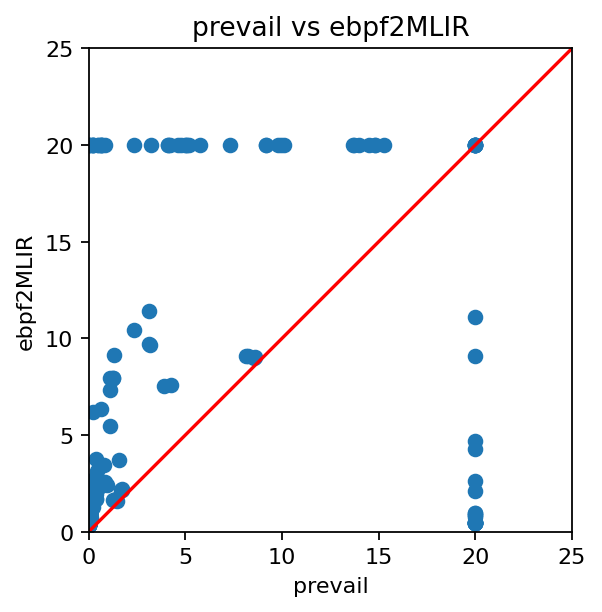

In [83]:
scatter_values('prevail_t', 'time', ref_results, current_results, "prevail", "ebpf2MLIR", TIMEOUTMAX)

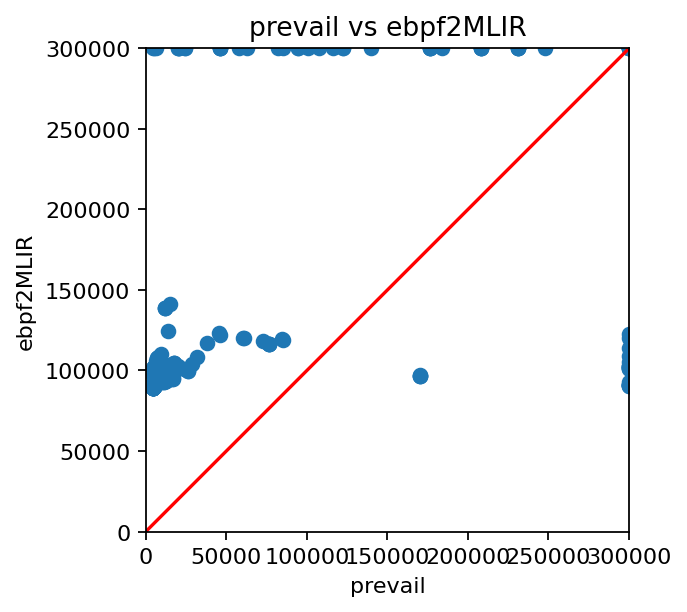

In [84]:
scatter_values('prevail_m', 'mem', ref_results, current_results, "prevail", "ebpf2MLIR", MEMOUTMAX)